# MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os

BATCH_SIZE = 128
NUM_EPOCHS = 20
lr = 0.001

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist/', train=False, transform=transform, download=False)

train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Model define

In [3]:
# Inspired by VGG Net

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),        # (16, 26, 26)
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),       # (16, 24, 24)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # (16, 12, 12)

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),       # (64, 10, 10)
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),       # (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),       # (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # (64, 4, 4)

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

model = Net(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [4]:
model

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=

In [5]:
def train(epoch, train_loss_list, train_acc_list):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    train_loss = train_loss / (batch_idx + 1)
    train_acc = correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print('Eopch: %d  Loss: %.5f  ACC: %.5f' % (epoch, train_loss, train_acc))
    

def test(epoch, test_loss_list, test_acc_list):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            
        test_loss = test_loss / (batch_idx + 1)
        test_acc = correct / total
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)
        print('Test  Loss: %.5f  ACC: %.5f' % (test_loss, test_acc))

        state = {
        'net': model.state_dict(),
        'acc': test_acc,
        'epoch': epoch,
        }
        
        dir_path = './checkpoints_mnist_net4'
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        path = os.path.join(dir_path, 'ckpt_%d_acc_%.5f.pth' % (epoch, test_acc))
        torch.save(state, path)

In [6]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(NUM_EPOCHS):
    train(epoch, train_loss_list, train_acc_list)
    test(epoch, test_loss_list, test_acc_list)

Eopch: 0  Loss: 0.76859  ACC: 0.84712
Test  Loss: 0.11908  ACC: 0.97196
Eopch: 1  Loss: 0.09213  ACC: 0.97536
Test  Loss: 0.06118  ACC: 0.98237
Eopch: 2  Loss: 0.05914  ACC: 0.98359
Test  Loss: 0.04512  ACC: 0.98698
Eopch: 3  Loss: 0.04491  ACC: 0.98760
Test  Loss: 0.03633  ACC: 0.98938
Eopch: 4  Loss: 0.03623  ACC: 0.99002
Test  Loss: 0.03344  ACC: 0.99028
Eopch: 5  Loss: 0.03037  ACC: 0.99185
Test  Loss: 0.02954  ACC: 0.99109
Eopch: 6  Loss: 0.02626  ACC: 0.99302
Test  Loss: 0.02617  ACC: 0.99199
Eopch: 7  Loss: 0.02243  ACC: 0.99427
Test  Loss: 0.02958  ACC: 0.99028
Eopch: 8  Loss: 0.01945  ACC: 0.99499
Test  Loss: 0.02231  ACC: 0.99359
Eopch: 9  Loss: 0.01706  ACC: 0.99568
Test  Loss: 0.02268  ACC: 0.99249
Eopch: 10  Loss: 0.01469  ACC: 0.99684
Test  Loss: 0.02128  ACC: 0.99299
Eopch: 11  Loss: 0.01301  ACC: 0.99700
Test  Loss: 0.02137  ACC: 0.99319
Eopch: 12  Loss: 0.01147  ACC: 0.99770
Test  Loss: 0.02173  ACC: 0.99249
Eopch: 13  Loss: 0.01022  ACC: 0.99788
Test  Loss: 0.02090  A

In [7]:
img_path = r'./images_mnist_4'
if not os.path.isdir(img_path):
    os.mkdir(img_path)

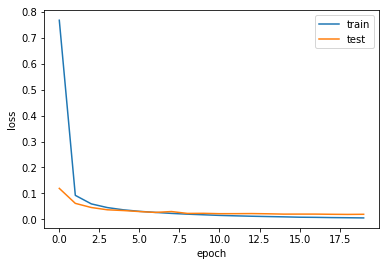

In [8]:
x = range(NUM_EPOCHS)
plt.plot(x, train_loss_list, test_loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.savefig(os.path.join(img_path, "loss.png"))
plt.show()

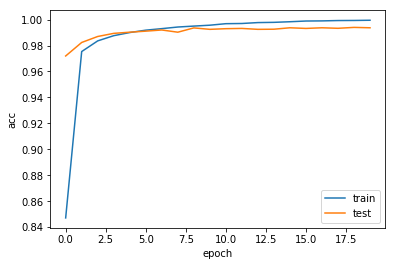

In [9]:
x = range(NUM_EPOCHS)
plt.plot(x, train_acc_list, test_acc_list)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train', 'test'])
plt.savefig(os.path.join(img_path, "acc.png"))
plt.show()

In [10]:
def test_model(model, split):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(split):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            
        test_loss = test_loss / (batch_idx + 1)
        test_acc = correct / total
        print('Loss: %.5f  ACC: %.5f' % (test_loss, test_acc))

# Choose Best Model and Test

In [11]:
restore_model_path = './checkpoints_mnist_net4/ckpt_18_acc_0.99399.pth'
model.load_state_dict(torch.load(restore_model_path)['net'])

<All keys matched successfully>

In [12]:
test_model(model, train_loader)

Loss: 0.00450  ACC: 0.99970


In [13]:
test_model(model, test_loader)

Loss: 0.01848  ACC: 0.99399
